## Introdução
Qual o objetivo do nosso projeto, coisas que buscamos executar.

#### Imports e carregamento de dados

In [23]:
# imports necessarios para o projeto
import kagglehub
import math
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split

# Fazero download da ultima versao do dataset
path = kagglehub.dataset_download("shashwatwork/cerebral-stroke-predictionimbalaced-dataset")
print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: C:\Users\stefa\.cache\kagglehub\datasets\shashwatwork\cerebral-stroke-predictionimbalaced-dataset\versions\1


['dataset.csv']

In [3]:
file_path = f"{path}/dataset.csv"
df = pd.read_csv(file_path)

#### Primeira inspeção dos dados
Aqui iremos verificar tamanho do dataset, tipo de variáveis, se existem valores nulos. Qual é a proporção de valores com a qual estaremos trabalhando

In [4]:
#verificacao quantitativa de linhas e colunas
print("Dimensões do dataset: ", df.shape)
#visualizando topo da tabela
display(df.head())

Dimensões do dataset:  (43400, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [5]:
#Informações gerais do dataset (colunas, tipo de dado, contagem e etc)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [6]:
# analise de descricao
df.groupby("stroke").describe()

id                                                               \
          count          mean           std   min      25%      50%      75%   
stroke                                                                         
0       42617.0  36317.641293  21075.614059   1.0  17997.0  36356.0  54507.0   
1         783.0  36788.836526  20890.023777  80.0  19798.5  36236.0  54865.5   

                     age             ... avg_glucose_level              bmi  \
            max    count       mean  ...               75%     max    count   
stroke                               ...                                      
0       72943.0  42617.0  41.741565  ...            111.67  291.05  41295.0   
1       72918.0    783.0  68.143448  ...            192.36  271.74    643.0   

                                                           
             mean       std   min   25%   50%   75%   max  
stroke                                                     
0       28.585371  7.788594  10.1  23.2  27.7  32.8  97.6  
1       29.868118  6.344873  14.3  25.7  29.1  33.0  56.6  

[2 rows x 48 columns]

In [7]:
# analise de valores nulos
df.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

##### Avaliando a distribuição da variável stroke (AVC)

Distribuição numérica:
 stroke
0    42617
1      783
Name: count, dtype: int64


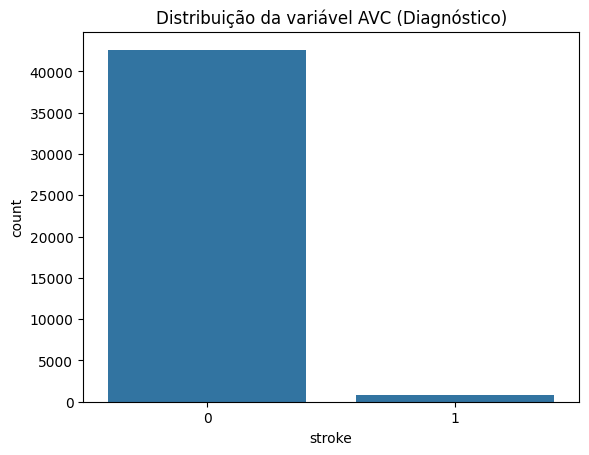

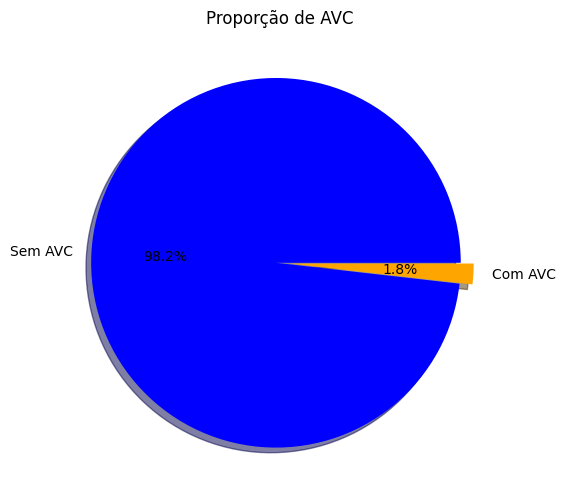

In [8]:
#variacao numerica
avc_count = df['stroke'].value_counts()
print("Distribuição numérica:\n",avc_count)

# exibindo em barras
sns.countplot(x='stroke', data=df)
plt.title('Distribuição da variável AVC (Diagnóstico)')
plt.show()

#exibindo a proporcao em porcentagem
plt.figure(figsize=(6,6))
plt.pie(avc_count.values, labels=['Sem AVC','Com AVC'], autopct='%1.1f%%', explode=(0.02,0.05), shadow=True, colors=['blue','orange'])
plt.title('Proporção de AVC')
plt.show();


Podemos notar que este é um dataset desbalanceado, pois a proporção de pessoas com AVC são baixos (Interessante para o trabalho por ter uma proximidade maior com relação a casos reais).

Nesta analise notamos que temos textos que deveram ser lidados para que o modelo possa ser treinado, temos também alguns dados nulos que terão que ser lidados.

Vamos fazer agora a remoção de colunas que não são necessárias como ID. Ajustes para os dados que são textos mantendo uma cópia do dataset original. E ajustar os valores nulos.

### Tratamento de dados

In [9]:
#removendo a coluna id
df.drop('id', axis=1, inplace=True)

#executnado tratamento de colunas nulas 
# Vamos preencher o BMI com a media de acordo com o Genero e Idade seguindo abordando com o método de grupos
df['bmi'] = df['bmi'].fillna(df.groupby(['gender', 'age'])['bmi'].transform('mean'))

# Nao vamos remover a categoria unknow dos fumantes para prevenir ruidos desnecessários *** Resposta Gemini 
# (Optou-se por manter a categoria 'Unknown' em smoking_status pois a ausência dessa informação pode representar um viés sistemático na coleta de dados hospitalares que o modelo pode capturar.) ***

# Verifica se sobrou algum nulo após o tratamento por grupos
nulos_restantes = df['bmi'].isnull().sum()
if nulos_restantes > 0:
    print(f"Atenção: Sobraram {nulos_restantes} nulos no BMI. Preenchendo com a mediana geral.")
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
else:
    print("✅ BMI 100% preenchido!")


Atenção: Sobraram 4 nulos no BMI. Preenchendo com a mediana geral.


In [10]:
# realizando duplicata de df para poder preencher com numeros as colunas que sao de categorias
# Criando a cópia e aplicando o get_dummies
# O drop_first=True evita a redundância estatística (multicolinearidade)
df_model = pd.get_dummies(df, drop_first=True)

# Verificando como as colunas ficaram
print(f"Colunas originais: {len(df.columns)}")
print(f"Colunas no df_model: {len(df_model.columns)}")
print("-" * 30)
print(df_model.columns.tolist())

Colunas originais: 11
Colunas no df_model: 16
------------------------------
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_never smoked', 'smoking_status_smokes']


### Exibindo gráficos para visualização geral dos dados individuais da colunas

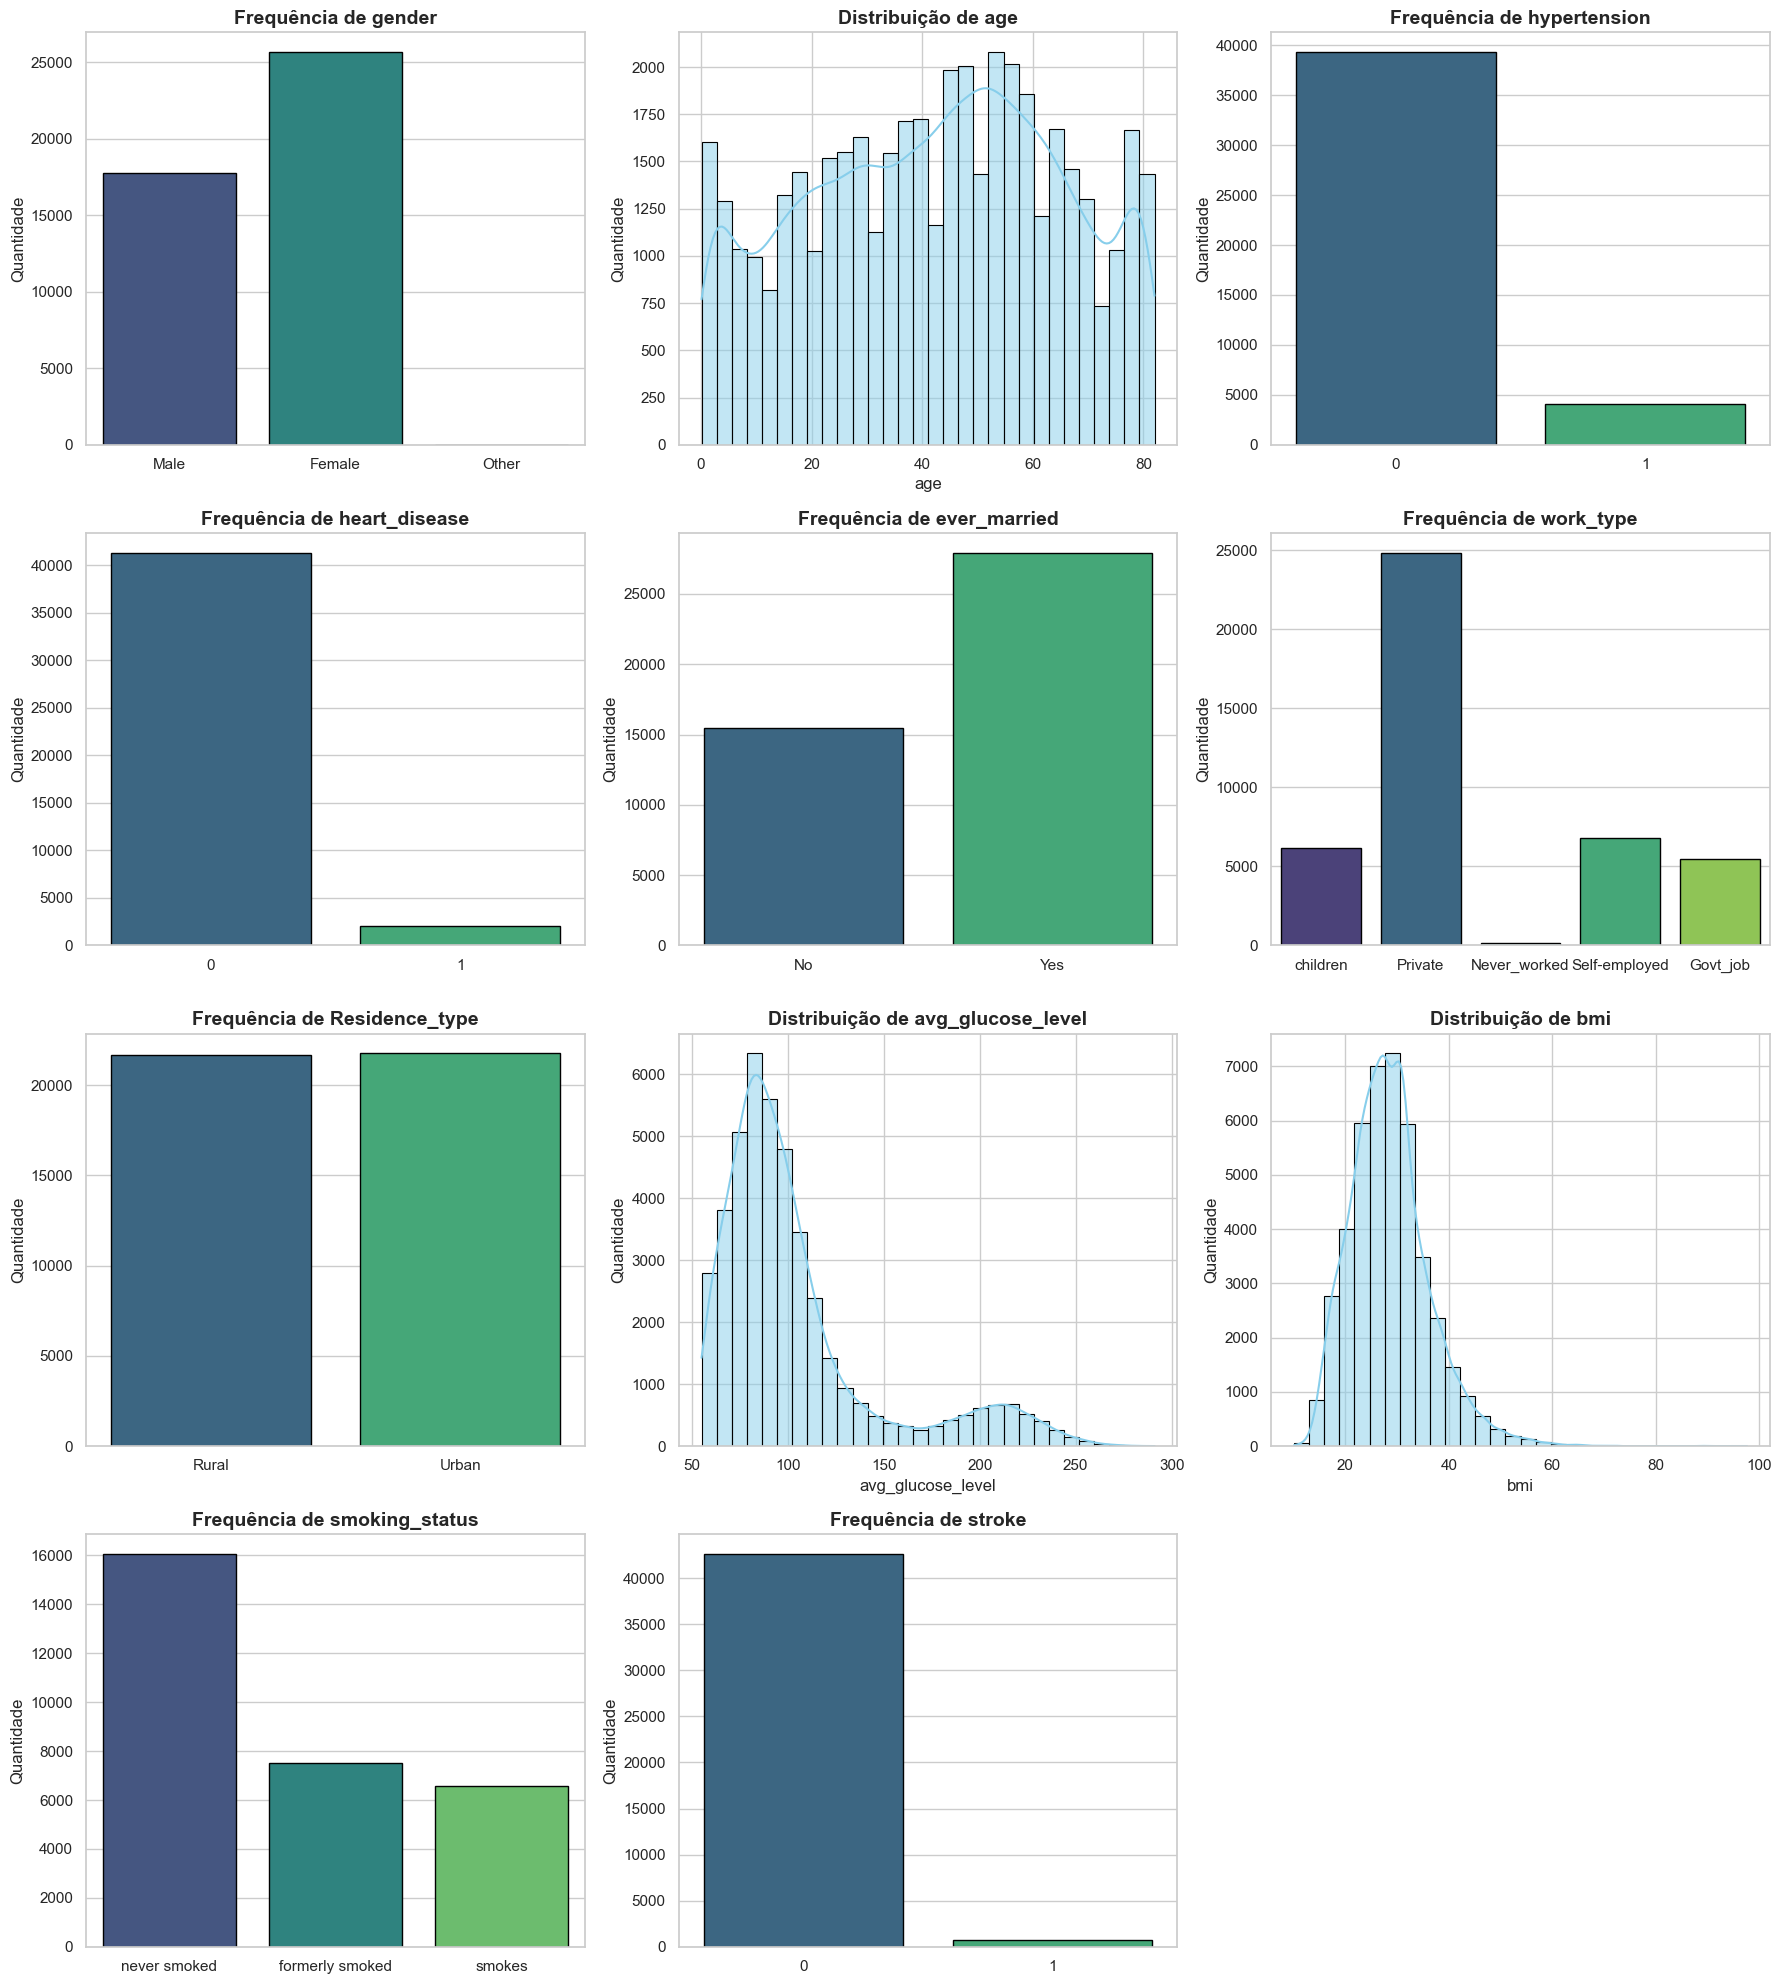

In [17]:
# 1. Definimos o dicionário de cores
cores_projeto = {0: "royalblue", 1: "darkorange"}

# 2. Configuramos o estilo e a paleta padrão
sns.set_theme(style="whitegrid")
sns.set_palette(list(cores_projeto.values()))

# 3. (Opcional) Ajuste fino para o Matplotlib usar essas cores por padrão
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=list(cores_projeto.values()))

# Usamos o df original para manter as legendas (Male, Female, Private, etc)
colunas = df.columns.tolist()
sns.set_theme(style="whitegrid")
n_cols = 3
n_rows = math.ceil(len(colunas) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(colunas):
    ax = axes[idx]
    
    # Se a coluna for numérica e tiver muitos valores (ex: age, bmi, glucose)
    if df[col].nunique() > 10 and df[col].dtype != 'object':
        sns.histplot(
            df[col].dropna(),
            bins=30,
            kde=True,
            color='skyblue',
            edgecolor='black',
            linewidth=0.8,
            ax=ax
        )
        ax.set_title(f'Distribuição de {col}', fontsize=14, fontweight='bold')
    
    # Se a coluna for categórica ou binária (ex: gender, hypertension, heart_disease, stroke)
    else:
        # Usamos countplot para manter o padrão visual do Seaborn
        sns.countplot(
            data=df, 
            x=col, 
            ax=ax, 
            palette='viridis', 
            edgecolor='black',
            hue=col,            # Adicionado para evitar avisos de futuras versões
            legend=False
        )
        ax.set_title(f'Frequência de {col}', fontsize=14, fontweight='bold')
        ax.set_xlabel('') # Limpa o label do eixo X para não repetir o título

    ax.set_ylabel('Quantidade')

# Remove eixos extras que ficarem em branco
for i in range(len(colunas), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Algumas observações feitas aqui

### Exibindo gráficos bivariadas para análise dos dados em relação ao fator de AVC

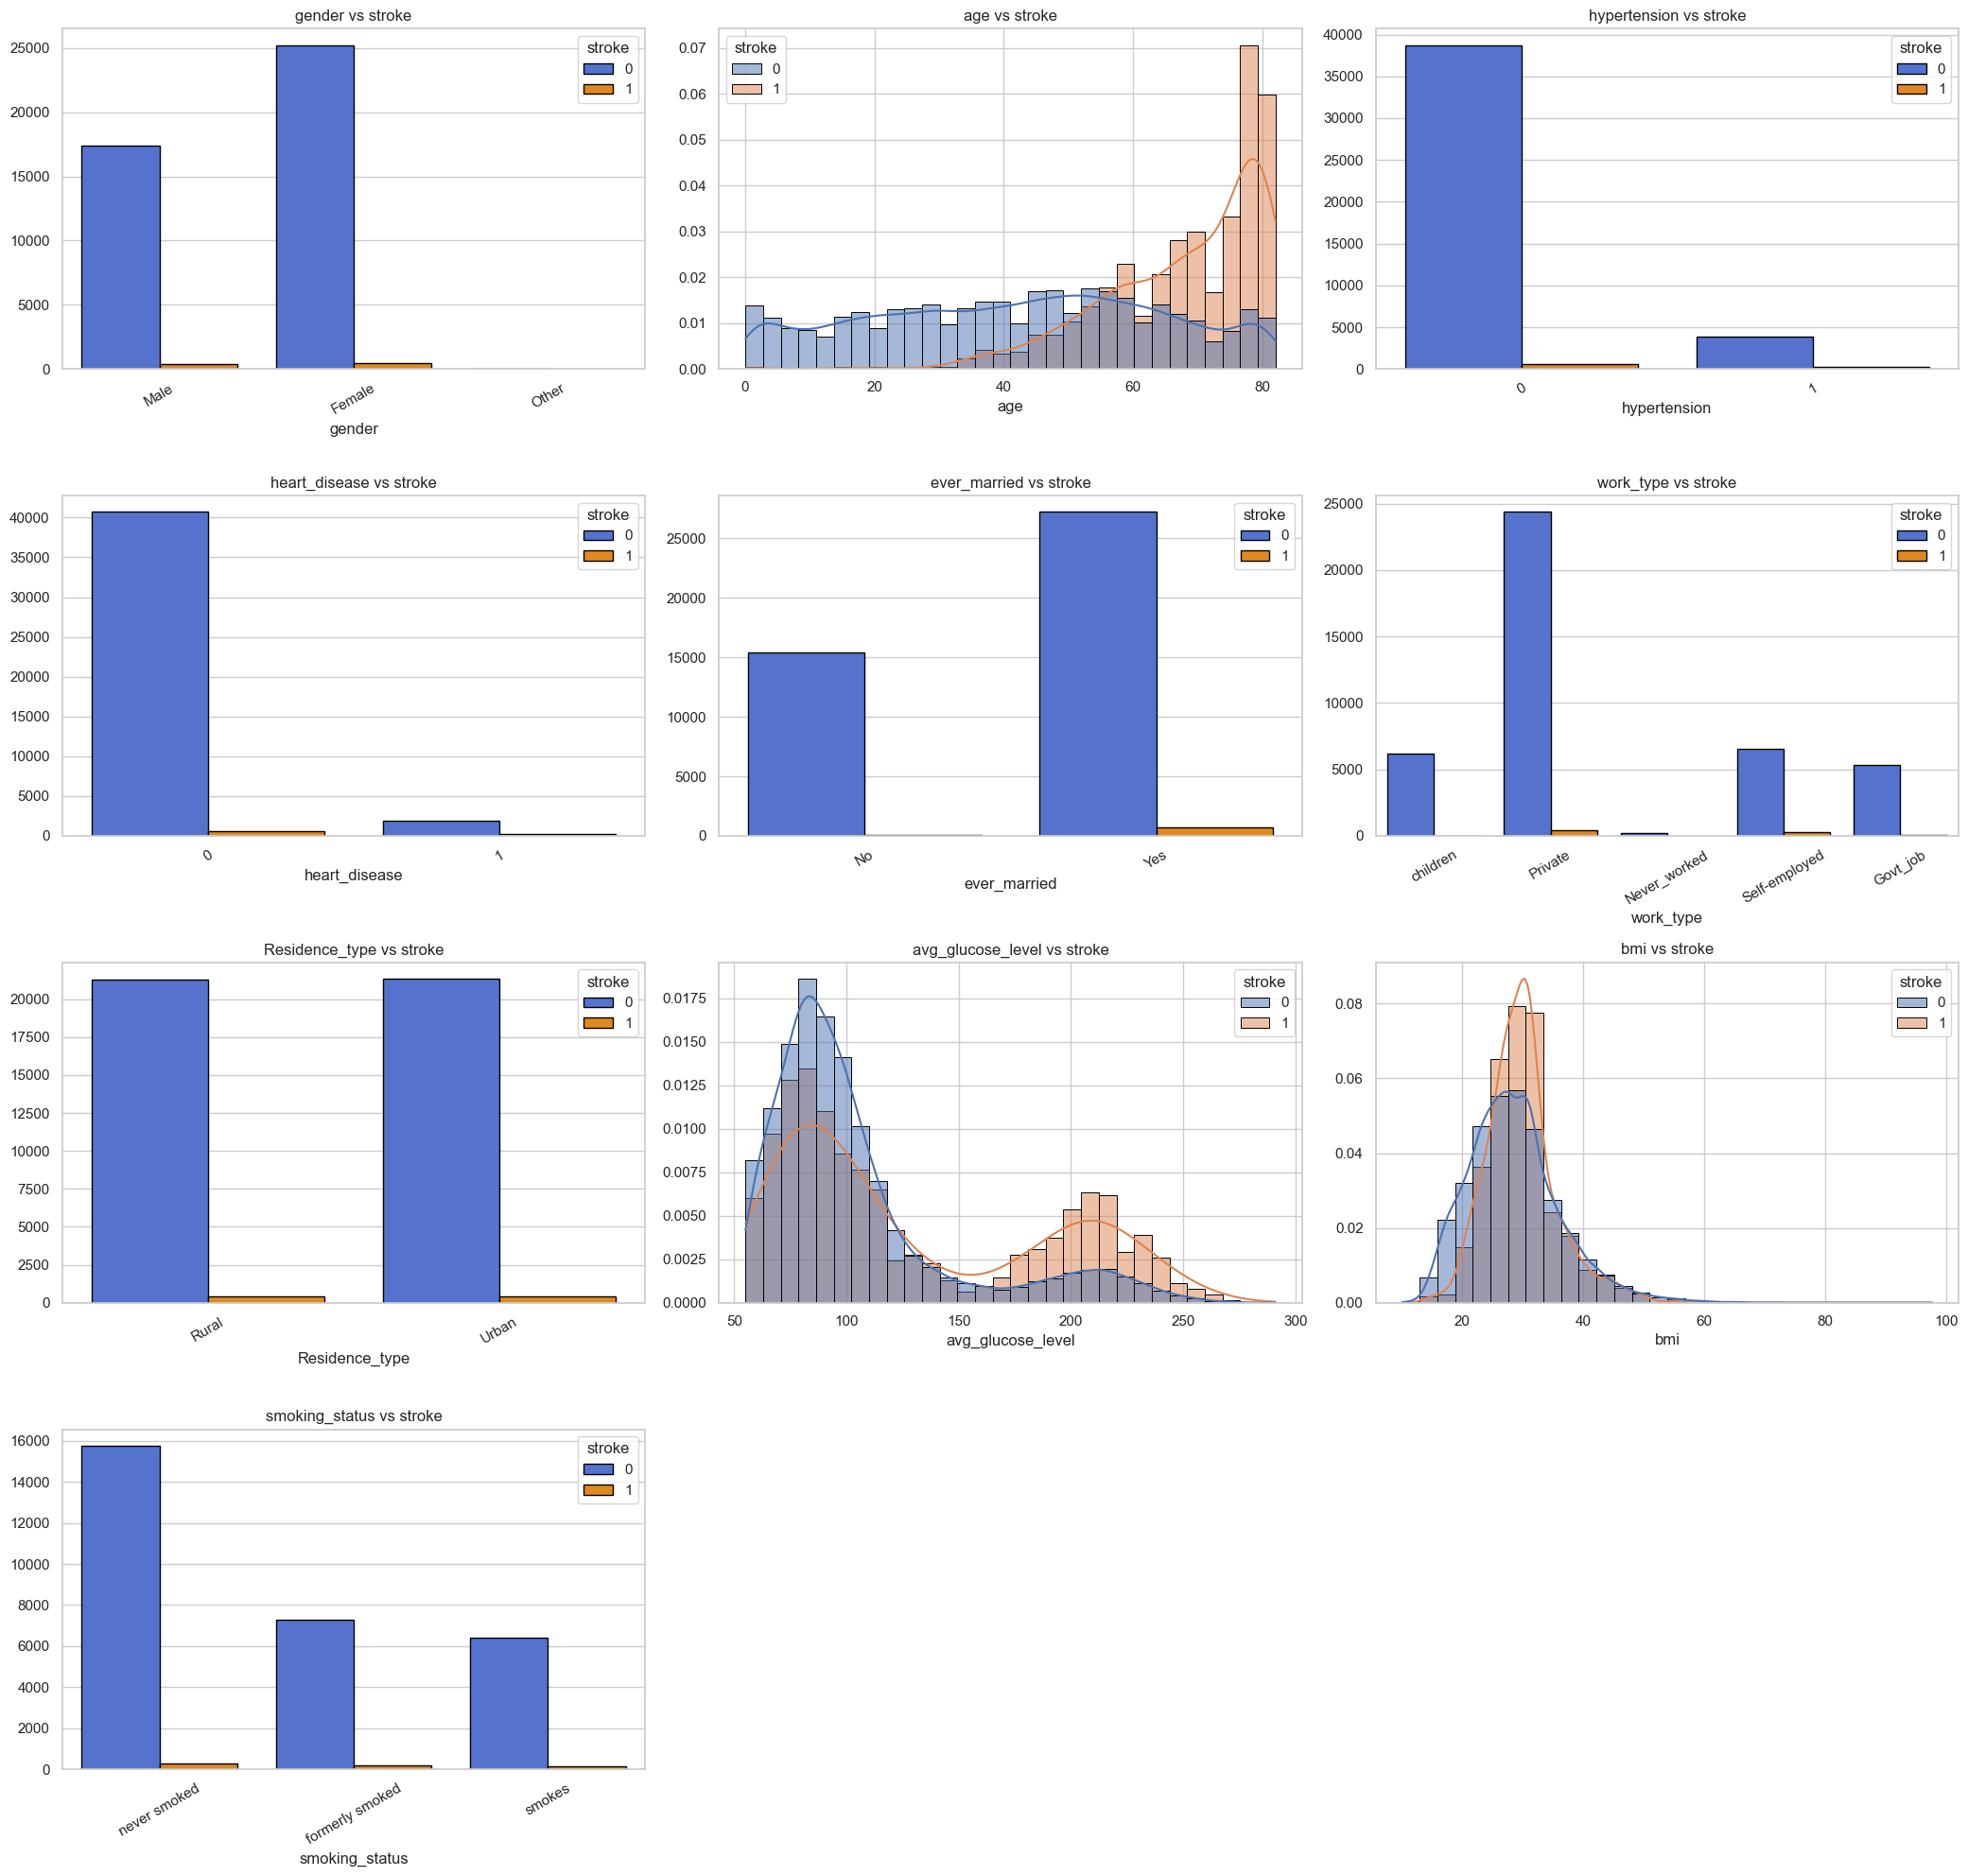

In [19]:
# Executando comparacao de todas as colunas do dataset com a coluna objetivo que é avc (stroke)
sns.set(style="whitegrid")

target = 'stroke'
features = [col for col in df.columns if col != target]

n_cols = 3
n_rows = math.ceil(len(features) / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(7 * n_cols, 5 * n_rows)
)
axes = axes.flatten()

for idx, col in enumerate(features):
    ax = axes[idx]
    unique_vals = df[col].nunique()

    # Numéricas contínuas
    if df[col].dtype != 'object' and unique_vals > 10:
        sns.histplot(
            data=df,
            x=col,
            hue=target,
            bins=30,
            kde=True,
            stat='density',
            common_norm=False,
            edgecolor='black',
            linewidth=0.7,
            ax=ax
        )
        ax.set_title(f'{col} vs {target}')

    # Categóricas / binárias
    else:
        sns.countplot(
            data=df,
            x=col,
            hue=target,
            edgecolor='black',
            ax=ax,
            palette=cores_projeto
        )
        ax.set_title(f'{col} vs {target}')
        ax.tick_params(axis='x', rotation=30)

    
    ax.set_ylabel('')

# Remove eixos vazios
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

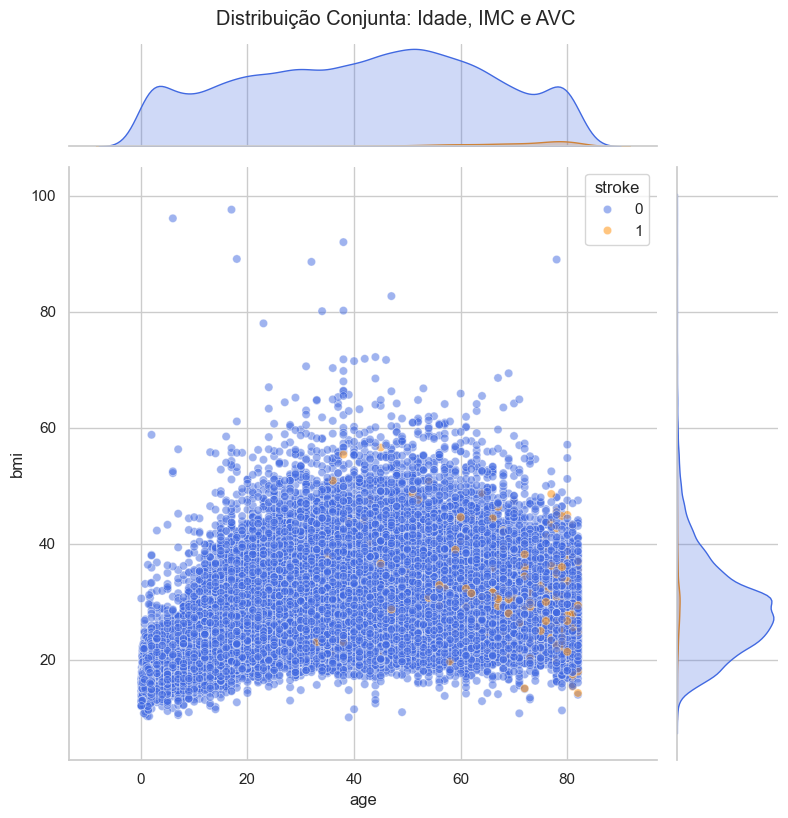

In [20]:
## Gráficos de comparação Testes
# Joint Plot (Análise Completa)
sns.jointplot(data=df, x='age', y='bmi', hue='stroke', palette=cores_projeto, alpha=0.5, height=8)
plt.suptitle('Distribuição Conjunta: Idade, IMC e AVC', y=1.02)
plt.show()

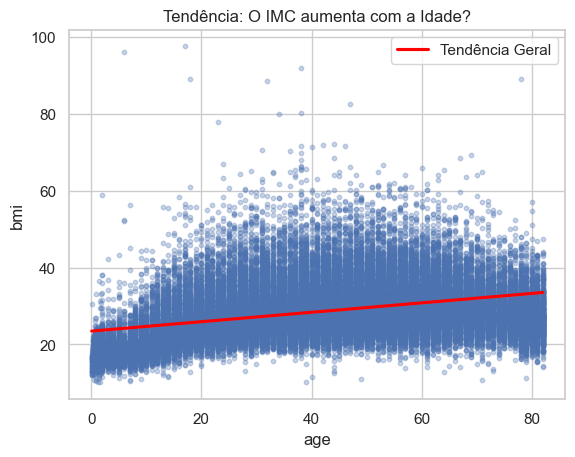

In [14]:
# Verificando interação de hiposes
sns.regplot(
    data=df, 
    x='age', 
    y='bmi', 
    scatter_kws={'alpha':0.3, 's':10}, 
    line_kws={'color':'red', 'label':'Tendência Geral'}
)

plt.title('Tendência: O IMC aumenta com a Idade?')
plt.legend()
plt.show()

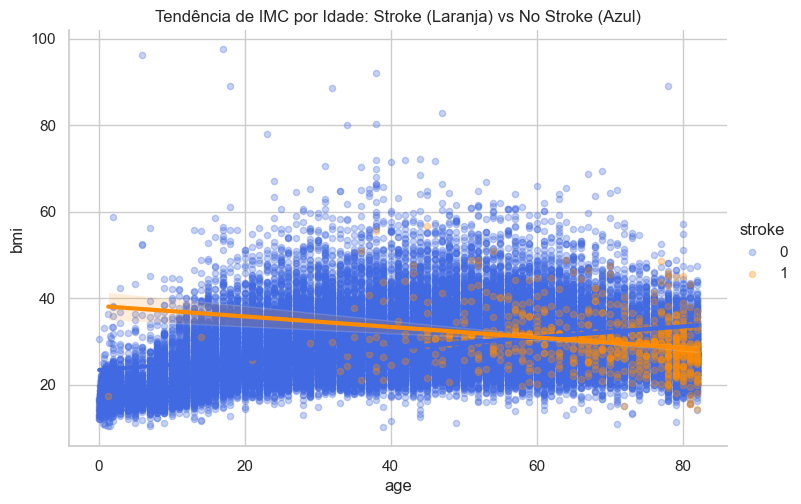

In [21]:
# O lmplot cria seu próprio tamanho de figura, não precisa de plt.figure
sns.lmplot(
    data=df, 
    x='age', 
    y='bmi', 
    hue='stroke', 
    palette=cores_projeto, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3, 's': 20}, # Pontos menores e transparentes
    line_kws={'linewidth': 3}            # Linha de tendência mais grossa
)

plt.title('Tendência de IMC por Idade: Stroke (Laranja) vs No Stroke (Azul)')
plt.show()

In [26]:
#separando valores para teste
x = df_model.drop(columns=['stroke'])
y = df_model['stroke']
print(f"Total de características (colunas): {x.shape[1]}")


Total de características (colunas): 15


In [27]:
# Dividindo 70% para treino e 30% para teste
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y  # MANTÉM A PROPORÇÃO DE AVC EM AMBOS OS LADOS
)

print(f"Treino: {x_train.shape[0]} amostras")
print(f"Teste: {x_test.shape[0]} amostras")

Treino: 30380 amostras
Teste: 13020 amostras
